<a href="https://colab.research.google.com/github/Valdi35/Markowitz_python/blob/main/Markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librairies, Données ...

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [101]:
!pip install plotly.express 

In [102]:
#Import librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from datetime import date
import bs4 as bs
import requests
import plotly_express as px

Download data

In [3]:
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
tickers = []
names = []
Sector = []
for row in table.findAll('tr')[1:]:
  ticker = row.findAll('td')[0].text
  name = row.findAll('td')[1].text
  secteur = row.findAll('td')[3].text
  tickers.append(ticker)
  names.append(name)
  Sector.append(secteur)

In [4]:
tickers = list(map(lambda s: s.strip(), tickers))
names = list(map(lambda s: s.strip(), names))
Sector = list(map(lambda s: s.strip(), Sector))

#Fichier avec toutes les informations
tickerdf = pd.DataFrame(tickers,columns=['ticker'])
namesdf = pd.DataFrame(names,columns=['Nom'])
Sectordf = pd.DataFrame(Sector,columns=['Industry'])

fichier = pd.concat([tickerdf, namesdf, Sectordf], axis=1)

In [5]:
start= datetime.datetime(2021,1,1)
data = yf.download(tickers ,start=start, period='1d')
#On conserve uniquement le prix ajuste et remplace les valeurs manquantes par 0
data = data['Adj Close']

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: None
- BRK.B: No data found, symbol may be delisted


In [6]:
data.drop(["BRK.B","BF.B"], axis=1, inplace=True)

In [7]:
data= pd.DataFrame(data, index=data.index)
data = data.fillna(method='ffill')

# Rendement, variance

In [8]:
AR = np.log(data/data.shift(1))

In [9]:
AR.dropna(inplace=True)

In [10]:
assetReturn = np.mean(AR)
assetVar = np.var(AR)

In [112]:
fig = px.scatter(x=assetVar,y=assetReturn,hover_name=assetReturn.index,width=800, height=600)

fig.update_layout(
    title="Rendements des actifs en fonction de la variance",
    xaxis_title="Variance",
    yaxis_title="Rendements"
)

fig.show()

# Formulation à rendement donné

In [12]:
#Objectifs de rendements totale = 11%
rho = 0.11

#Montant investi dans le portefeuille
S = 1
e = np.ones(len(assetReturn))

#Determiner un poids aleatoire pour chaque actif compris entre 0 et 1
#La somme des poids doit etre egale a 1 --> portefeuille equipondere
w = np.array([[1/len(assetReturn)] * len(assetReturn)])

#Construire la matrice de covariance
assetCov = np.cov(AR.transpose())

#Calcul du risk global du portefeuille (fonction a minimiser en fonction de w)
riskPort = np.dot(np.dot(w, assetCov),w.transpose())

In [13]:
#Contraintes :
"""
- Poids >= 0 , pas de vente a decouvert

- Poids * rendements moyens doivent etre superieur ou egale a l'objectifs de rendements

- La somme des poids doit etre egale a la somme investi S
"""

from scipy.optimize import LinearConstraint, Bounds, minimize
bounds = Bounds(0, 1)
linear_constraints = LinearConstraint([assetReturn,e],[rho,0.9],[np.inf,1.1])

def optimRisk(x,sigma):
  """
  Sigma : Covariance matrix of portfolio assets
  x : initially weighted portfolio 
  """
  return np.dot(np.dot(x,sigma),x.T)

res = minimize(
    optimRisk,
    x0=w.T,
    args=assetCov,
    method='SLSQP',
    constraints=linear_constraints,
    bounds=bounds
)

In [14]:
opt_weight = res.x
opt_weight.shape

(503,)

Calcul de la variance du portefeuille optimale

In [15]:
#Le risque global quand le niveau de rendement exige est de 8%
globalRiskPort = np.dot(np.dot(opt_weight, assetCov),opt_weight.transpose())

In [16]:
globalRiskPort

0.0007277412970566411

Visualisation de la repartition des actifs

In [115]:
d = {'return': assetReturn.values, 'variance': assetVar.values, 'weight':opt_weight}
df_1 = pd.DataFrame(data=d, index=assetReturn.index)

In [119]:
fig = px.scatter(df_1, x='variance',y='return',color='weight'
                 ,width=800, height=600)

fig.update_layout(
    title="Rho = 0.11",
    xaxis_title="Variance",
    yaxis_title="Rendements"
)

fig.show()

# Formulation à risque controlé

In [18]:
#On fixe le niveau de risque attendu
sigDiag = np.diag(assetCov)
riskTarget = 0.008
bounds = Bounds(0, 1)
linear_constraints = LinearConstraint([sigDiag,e],[0,S-0.001],[riskTarget,S+0.001])

def optimReturn(x,sigma,r):
  """
  Sigma : Covariance matrix of portfolio assets
  x : initially weighted portfolio 
  """
  return np.dot(np.dot(x,sigma),x.T) - np.dot(w,r)

res1 = minimize(
    optimReturn,
    x0=w.T,
    args=(assetCov,assetReturn),
    constraints=linear_constraints,
    bounds=bounds
)

In [19]:
#La variance du portefeuille obtenu
riskPort_2 = res.fun

In [20]:
opt_weight_2 = res.x

In [120]:
df_1['weight2'] = opt_weight_2

In [121]:
fig = px.scatter(df_1, x='variance',y='return',color='weight2'
                 ,width=800, height=600)

fig.update_layout(
    title="Sigma : 0.008",
    xaxis_title="Variance",
    yaxis_title="Rendements"
)

fig.show()

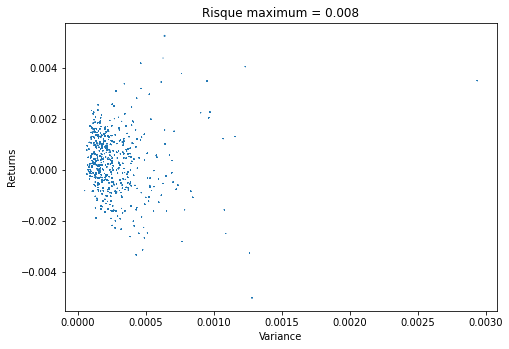

In [21]:
#Repartition des poids par actifs
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.scatter(assetVar,assetReturn, s=opt_weight_2)
axes.set_xlabel('Variance')
axes.set_ylabel('Returns')
axes.set_title('Risque maximum = 0.008')
plt.show()

# Analyse sur les 10 meilleures actifs

In [30]:
#set a col name
d = {'return': assetReturn.values, 'variance': assetVar.values, 'weight':opt_weight_2}
df = pd.DataFrame(data=d, index=assetReturn.index)

#extract 10 best
top_10 = df.nlargest(10,'weight')

In [35]:
#Returns & variance
assetReturn_10 = top_10['return']
assetVar_10 = top_10['variance']

In [44]:
#Params
cov_mat = np.zeros((10,10))

In [71]:
#Matrice de covariance entre les 10 meilleures actifs
for i in range(len(assetReturn_10)):
  for j in range(len(assetReturn_10)):
    cov_mat[i,j] = np.cov([assetReturn_10.iloc[i],assetReturn_10.iloc[j]])

In [92]:
sigDiag = np.diag(cov_mat)
riskTarget = 0.002
bounds = Bounds(0, 1)
e = np.ones(len(assetReturn_10))
w = np.array([[1/len(assetReturn_10)] * len(assetReturn_10)])

linear_constraints = LinearConstraint([sigDiag,e],[0,S-0.001],[riskTarget,S+0.001])

def optimReturn(x,sigma,r):
  """
  Sigma : Covariance matrix of portfolio assets
  x : initially weighted portfolio 
  """
  return np.dot(np.dot(x,sigma),x.T) - np.dot(w,r)

res_10 = minimize(
    optimReturn,
    x0=w.T,
    args=(cov_mat,assetReturn_10),
    constraints=linear_constraints,
    bounds=bounds
)

In [93]:
w_10 = res_10.x

Avec les 10 meilleurs actifs de l'indice, on obtient un portefeuille equipondérée dans la solution optimale

Les limites de l'approche de Markowitz constaté ici : - L’optimisation par le critère rendement/risque est très sensible aux variations du rendement 
espéré du portefeuille. En effet, une anticipation du rendement d’un actif ayant varié à la hausse, 
viendrait augmenter de manière significative la part de cet actif dans le portefeuille (BlackLitterman, 1990).

# Formulation pénalisée

In [ ]:
bounds = Bounds(0, 1)
linear_constraints = LinearConstraint(e,S-0.001,S+0.001)

def ridgeOptim(x,sigma,r):
  """
  Sigma : Covariance matrix of portfolio assets
  x : initially weighted portfolio 
  r : Le vecteur de rendement moyen des actifs
  lambda : paramètre de régularisation
  """
  return - (np.dot(w,r) - np.dot(np.dot(x,sigma),x.T) - lambda * (np.dot(np.dot(x,np.eye(len(x))),x.T)))

res_10 = minimize(
    ridgeOptim,
    x0=w.T,
    args=(assetCov,assetReturn),
    constraints=linear_constraints,
    bounds=bounds
)